In [1]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

<h3> Load Dataset </h3>

In [2]:
data = pd.read_csv('datasets/nyc_bb_bicyclist_counts.csv', infer_datetime_format=True, parse_dates=[0], index_col=[0]).dropna()

In [3]:
data.head()

,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
2017-04-01,46.0,37.0,0.00,606
2017-04-02,62.1,41.0,0.00,2021
2017-04-03,63.0,50.0,0.03,2470
2017-04-04,51.1,46.0,1.18,723
2017-04-05,63.0,46.0,0.00,2807


<h3> Feature Engineering </h3>

Create new features like month, dayofweek and day which can be derived from date.

In [4]:
ds = data.index.to_series()
data['MONTH'] = ds.dt.month
data['DAY_OF_WEEK'] = ds.dt.dayofweek
data['DAY'] = ds.dt.day

In [5]:
data.head()

,HIGH_T,LOW_T,PRECIP,BB_COUNT,MONTH,DAY_OF_WEEK,DAY
Date,,,,,,,
2017-04-01,46.0,37.0,0.00,606,4,5,1
2017-04-02,62.1,41.0,0.00,2021,4,6,2
2017-04-03,63.0,50.0,0.03,2470,4,0,3
2017-04-04,51.1,46.0,1.18,723,4,1,4
2017-04-05,63.0,46.0,0.00,2807,4,2,5


<h3> Problem Statement </h3>

<h2>BB_COUNT ~ DAY  + DAY_OF_WEEK + MONTH + HIGH_T + LOW_T + PRECIP</h2>

In [6]:
mask = np.random.rand(len(data)) < 0.8
train_data = data[mask]
test_data = data[~mask]

print('Training dataset length: '+str(len(train_data)))
print('Testing dataset length: '+str(len(test_data)))

# Define the dependent and independent variables
y_train = train_data['BB_COUNT']
X_train = train_data[['HIGH_T', 'LOW_T', 'PRECIP', 'MONTH', 'DAY_OF_WEEK', 'DAY']]

y_test = test_data['BB_COUNT']
X_test = test_data[['HIGH_T', 'LOW_T', 'PRECIP', 'MONTH', 'DAY_OF_WEEK', 'DAY']]

# Add a constant term to the independent variables (for intercept in the regression)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

Training dataset length: 172
Testing dataset length: 42


<h3> Poisson Regression Model </h3>

The **Poisson Regression Model** make the variance = mean assumption about the data.

In [7]:
# Fit the linear regression model using Poisson Model
poisson_reg_model = sm.GLM(y_train,X_train,family=sm.families.Poisson()).fit()

# Display the summary of the regression results
print(poisson_reg_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  172
Model:                            GLM   Df Residuals:                      165
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12145.
Date:                Tue, 16 Jan 2024   Deviance:                       22628.
Time:                        00:03:25   Pearson chi2:                 2.28e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.9863      0.013    550.103      

<h3> Regression Diagnostics </h3>

<h4> Goodness of Fit </h4>

The observed statistic of **Deviance** and **Pearson Chi-Squared** are **very large** as compared to standard Chi-Squared table which suggests that Poisson Regression Model has fit the training data poorly.</br> 
The low performance of Poisson Regression Model is because the data did not obey the **variance = mean** criterion required by the Poisson regression model.

In [8]:
print('variance='+str(data['BB_COUNT'].var()))
print('mean='+str(data['BB_COUNT'].mean()))

variance=730530.6601948135
mean=2680.042056074766


<h4> Prediction on Test Dataset </h4>

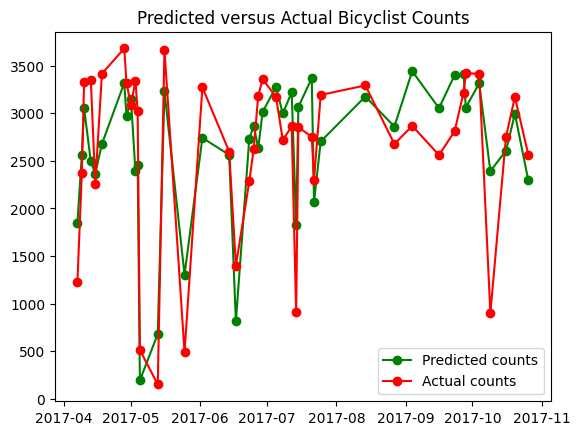

In [9]:
# Plot Predicted versus Actual Counts on test dataset
y_cap_poisson_reg = poisson_reg_model.predict(X_test)

plt.title('Predicted versus Actual Bicyclist Counts')
plt.plot(X_test.index, y_cap_poisson_reg, 'go-', label='Predicted counts')
plt.plot(X_test.index, y_test, 'ro-', label='Actual counts')

plt.legend()
plt.show()

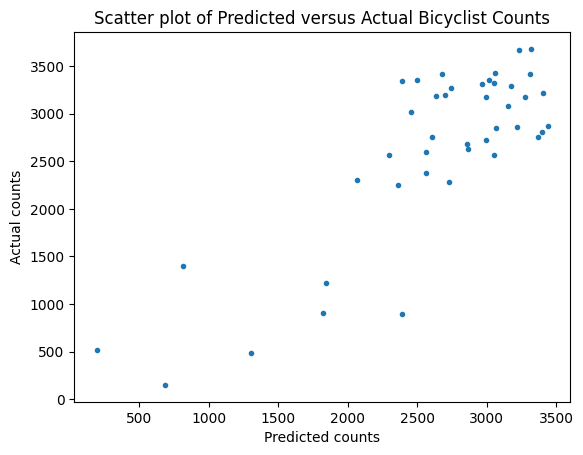

In [10]:
# Scatter plot of Predicted versus Actual Counts on test dataset
plt.title('Scatter plot of Predicted versus Actual Bicyclist Counts')
plt.scatter(x=y_cap_poisson_reg, y=y_test, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

<h3> Negative Bionomial Regression Model </h3>

The low performance of **Poisson Regression Model** is because the data did not obey the variance = mean criterion required by the Poisson regression model. The **Negative Binomial (NB) Regression Model** is one such model that does not make the variance = mean assumption about the data.

Instead, the NB model requires us to define a new parameter α which it uses to express the variance in terms of the mean as follows:

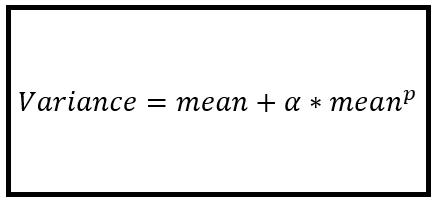

The **p=1** case is referred as **NB1 Model**.
The **p=2** case is referred as **NB2 Model**. <br>
**NOTE:** If α is zero, then variance = mean and model reduces to Poisson regression model.

We will use **NB2 Model**. Summary of **NB2 Regression Model**: </br>
**STEP 1:** Fit the Poisson regression model on the data set. This will give us the vector of fitted rates λ. </br>
**STEP 2:** Fit the aux OLS regression model on the data set. This will give us the value of α.</br>
**STEP 3:** Use the α from STEP 2 to fit the NB2 regression model to the data set.</br>
**STEP 4:** Use the fitted NB2 model to make predictions about expected counts on the test data set.</br>
**STEP 5:** Test the goodness-of-fit of the NB2 model.

In [11]:
# step 1 (use poisson_reg_model from above)
train_data['BB_LAMBDA'] = poisson_reg_model.mu

# step 2
train_data['AUX_OLS_DEP'] = train_data.apply(lambda x: ((x['BB_COUNT'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1).tolist()

# step 3
aux_ols_model = sm.OLS(train_data['AUX_OLS_DEP'], train_data[['BB_LAMBDA']]).fit()
alpha = aux_ols_model.params[0]
print(alpha)

0.03963304405717258


**Is α statistically significant?** </br>
Recollect that if α is zero, then model reduced to Poisson regression model.

In [12]:
alpha_tstatistics = aux_ols_model.tvalues[0]
print(alpha_tstatistics)

5.29818725528209


t-statistics is clearly greater than **2.58** which corresponds 99% confidence level that is α statistically significantly.

In [13]:
# Fit the linear regression model using Negative Bionomial Model
nb2_reg_model = sm.GLM(y_train,X_train,family=sm.families.NegativeBinomial(alpha=alpha)).fit()

# Display the summary of the regression results
print(nb2_reg_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  172
Model:                            GLM   Df Residuals:                      165
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1368.1
Date:                Tue, 16 Jan 2024   Deviance:                       281.09
Time:                        00:03:25   Pearson chi2:                     275.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.8795
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.7312      0.121     55.492      

<h3> Regression Diagnostics </h3>

<h4> Goodness of Fit </h4>

The observed statistic of **Deviance** and **Pearson Chi-Squared** are **smaller** as compared to Poisson Regression Model which suggests Negative Bionomial Regression Model is **much better** than Poisson regression model.</br> 

Also, As per **LR test**, Negative Bionomial Regression Model has much better goodness-of-fit as compared to Poisson Regression Model because Log-likelihood for Negative Bionomial Regression Model is much greater than Poisson Regression Model which suggests better ML estimates of regression parameters in case of Negative Bionomial Regression Model.

<h4> Prediction on Test Dataset </h4>

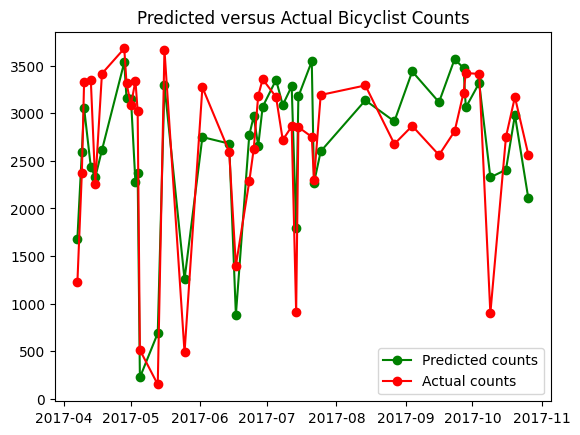

In [14]:
# Plot Predicted versus Actual Counts on test dataset
y_cap_nb_reg = nb2_reg_model.predict(X_test)

plt.title('Predicted versus Actual Bicyclist Counts')
plt.plot(X_test.index, y_cap_nb_reg, 'go-', label='Predicted counts')
plt.plot(X_test.index, y_test, 'ro-', label='Actual counts')

plt.legend()
plt.show()

The Negative Binomial regression model (often referred to as a Poisson-Gamma mixture) turns out to be an excellent model for many real-world counts datasets.

<h3> GP-1 (Generalized Poisson-1) Regression Model </h3>

The **GP-1 (Generalized Poisson-1) Regression Model** also does not make the variance = mean assumption about the data.

In [15]:
# Fit the linear regression model using (Generalized Poisson-1) Model
gp1_reg_model = sm.GeneralizedPoisson(y_train, X_train, p=1).fit()

# Display the summary of the regression results
print(gp1_reg_model.summary())

         Current function value: 7.793391
         Iterations: 24
         Function evaluations: 57
         Gradient evaluations: 46
                    GeneralizedPoisson Regression Results                     
Dep. Variable:               BB_COUNT   No. Observations:                  172
Model:             GeneralizedPoisson   Df Residuals:                      165
Method:                           MLE   Df Model:                            6
Date:                Tue, 16 Jan 2024   Pseudo R-squ.:                 0.08099
Time:                        00:03:25   Log-Likelihood:                -1340.5
converged:                      False   LL-Null:                       -1458.6
Covariance Type:            nonrobust   LLR p-value:                 3.537e-48
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.8856      0.138     49.740      0.000       6.614       

<h3> Regression Diagnostics </h3>

<h4> Goodness of Fit </h4>

As per **LR test**, GP-1 (Generalized Poisson-1) Regression Model has much better goodness-of-fit as compared to Poisson Regression Model as well as slightly better than Negative Bionomial Regression Model because Log-likelihood for GP-1 (Generalized Poisson-1) Regression Model is much greater than Poisson Regression Model and slightly better than Negative Bionomial Regression Model which suggests better ML estimates of regression parameters in case of GP-1 (Generalized Poisson-1) Regression Model.

<h4> Prediction on Test Dataset </h4>

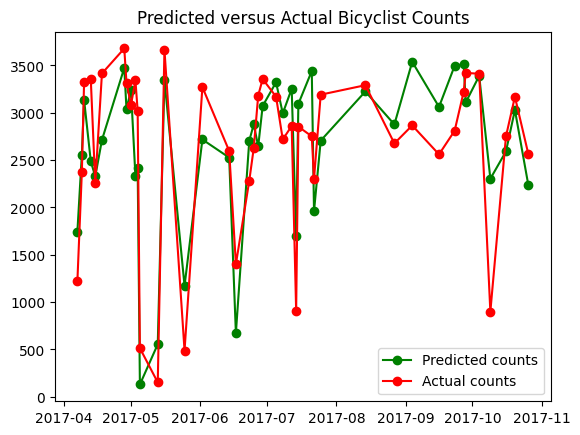

In [16]:
# Plot Predicted versus Actual Counts on test dataset
y_cap_gp1_reg = gp1_reg_model.predict(X_test)

plt.title('Predicted versus Actual Bicyclist Counts')
plt.plot(X_test.index, y_cap_gp1_reg, 'go-', label='Predicted counts')
plt.plot(X_test.index, y_test, 'ro-', label='Actual counts')

plt.legend()
plt.show()

<h3> GP-2 (Generalized Poisson-2) Regression Model </h3>

The **GP-2 (Generalized Poisson-2) Regression Model** also known as **Restricted Generalized Poisson Regression Model** also does not make the variance = mean assumption about the data.

In [17]:
# Fit the linear regression model using (Generalized Poisson-2) Model
gp2_reg_model = sm.GeneralizedPoisson(y_train, X_train, p=2).fit()

# Display the summary of the regression results
print(gp2_reg_model.summary())

Optimization terminated successfully.
         Current function value: 8.031059
         Iterations: 21
         Function evaluations: 31
         Gradient evaluations: 31
                    GeneralizedPoisson Regression Results                     
Dep. Variable:               BB_COUNT   No. Observations:                  172
Model:             GeneralizedPoisson   Df Residuals:                      165
Method:                           MLE   Df Model:                            6
Date:                Tue, 16 Jan 2024   Pseudo R-squ.:                 0.05296
Time:                        00:03:25   Log-Likelihood:                -1381.3
converged:                       True   LL-Null:                       -1458.6
Covariance Type:            nonrobust   LLR p-value:                 8.652e-31
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.4348      0.172   

<h3> Regression Diagnostics </h3>

<h4> Goodness of Fit </h4>

As per **LR test**, GP-2 (Generalized Poisson-2) Regression Model has much better goodness-of-fit as compared to Poisson Regression Model because Log-likelihood for GP-2 (Generalized Poisson-2) Regression Model is much greater than Poisson Regression Model which suggests better ML estimates of regression parameters in case of GP-2 (Generalized Poisson-2) Regression Model.

<h3> OLS Regression Model </h3>

In [18]:
# Fit the linear regression model using Poisson Model
ols_reg_model = sm.OLS(y_train,X_train).fit()

# Display the summary of the regression results
print(ols_reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:               BB_COUNT   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     31.71
Date:                Tue, 16 Jan 2024   Prob (F-statistic):           3.46e-25
Time:                        00:03:25   Log-Likelihood:                -1335.9
No. Observations:                 172   AIC:                             2686.
Df Residuals:                     165   BIC:                             2708.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         212.6886    352.937      0.603      

<h3> Regression Diagnostics </h3>

<h4> Goodness of Fit </h4>

As per **LR test**, OLS Regression Model has much better goodness-of-fit as compared to Poisson Regression Model as well as slightly better than Negative Bionomial Regression Model because Log-likelihood for OLS Regression Model is much greater than Poisson Regression Model and slightly better than Negative Bionomial Regression Model which suggests better ML estimates of regression parameters in case of OLS Regression Model.

<h4> Prediction on Test Dataset </h4>

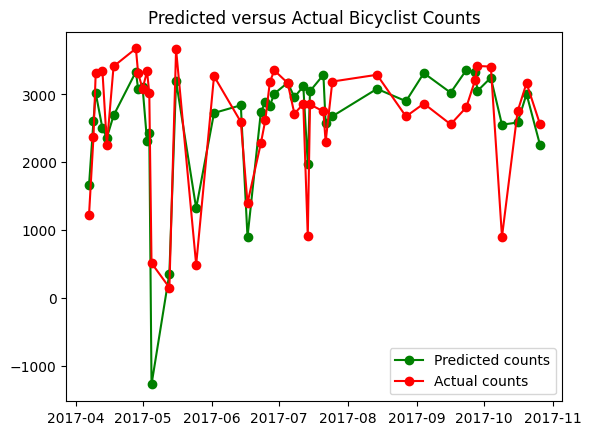

In [19]:
# Plot Predicted versus Actual Counts on test dataset
y_cap_ols_reg = ols_reg_model.predict(X_test)

plt.title('Predicted versus Actual Bicyclist Counts')
plt.plot(X_test.index, y_cap_ols_reg, 'go-', label='Predicted counts')
plt.plot(X_test.index, y_test, 'ro-', label='Actual counts')

plt.legend()
plt.show()

<h4> Drawbacks of OLS as Comapared to Count Based Models </h4>

1. The forecasted counts are not integers, which is a classic drawback of applying a OLS regression model to counts based data. In this case, we can work around this drawback by rounding up or rounding down the predictions.
2. Notice above that one of the predicted bicyclist counts is negative. This is yet another classic shortcoming of a OLS regression model when it’s applied to counts based data. In some cases, we can work around this drawback by simply rounding up the negative values to zero.

<h2> Summary </h2>

1. The Poisson Regression Model assumes that the variance of the counts based data is same as the mean value. This assumption is often violated by real world data sets which are either over-dispersed (variance is greater than mean) or under-dispersed (variance is less than mean).
2. Hence we need to use other models for counts based data such as the Negative Binomial Regression Model or Generalized Poisson Regression models (GP-1 and GP-2) which do not assume that the data is equi-dispersed. Such models assume that the variance is some function of the mean.
3. The OLS Regression Model perform much better than Poisson Regression Model and slightly better or more or less around same Log-likelihood than Negative Binomial Regression Model and Generalized Poisson Regression models (GP-1 and GP-2) for the counts based data but it has two major drawbacks as Comapared to Count Based Models. 
4. In spite of skewness in counts data and the OLS Regression model’s propensity for generating negative and fractional counts, OLS Regression model can be a viable regression model for counts based data sets. 
5. Just because the OLS Regression model performance has been good on the dataset used in this experiment, an OLS Regression Model will not always work out quite as well on all counts data sets. The inherent weakness of OLS regression on counts data is bound to show through for more ‘challenging’ data sets.